In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch import nn
import torchvision
import torch.nn.functional as F
import random

# set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data Preparation

In [2]:
# read datafile (h5)

#Don't run after having saved the data
#Uncomment and re-run if you need to re-save the data
"""
f = h5py.File("Galaxy10.h5")
images = f.get("images")
labels = f.get("ans")
img_in = np.array(images)
lab_in = np.array(labels)

# write data to tensors
imgs = torch.from_numpy(img_in)
labs = torch.from_numpy(lab_in)
imgs = [x.permute(2, 0, 1) for x in imgs]
np.save("labels.npy", labs)

# data augmentation based on model input
MOD_INPUT_SIZE = 224
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(MOD_INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
imgs = torch.stack([data_transform(imgs[i]) for i in range(len(imgs))])
torch.save(imgs, "images_tensor.pt")
"""


'\nf = h5py.File("Galaxy10.h5")\nimages = f.get("images")\nlabels = f.get("ans")\nimg_in = np.array(images)\nlab_in = np.array(labels)\n\n# write data to tensors\nimgs = torch.from_numpy(img_in)\nlabs = torch.from_numpy(lab_in)\nimgs = [x.permute(2, 0, 1) for x in imgs]\nnp.save("labels.npy", labs)\n\n# data augmentation based on model input\nMOD_INPUT_SIZE = 224\ndata_transform = transforms.Compose([\n        transforms.ToPILImage(),\n        transforms.RandomResizedCrop(MOD_INPUT_SIZE),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n    ])\nimgs = torch.stack([data_transform(imgs[i]) for i in range(len(imgs))])\ntorch.save(imgs, "images_tensor.pt")\n'

In [3]:
def augment(X, l, labelstats):
    """Duplicate one image (while rotating it) according to probability - try to even out the counts"""
    out = [X, torch.flip(X, dims=[2])]
    for _ in range(3):
        out.append(torch.rot90(out[-2], k=1, dims=[1, 2]))
        out.append(torch.flip(out[-1], dims=[2]))
    out2 = [X]
    outl = []
    for i in range(7):
        if random.random() < labelstats[l]:
            out2.append(out[i+1])
    return out2, [l] * len(out2)

def augment_dataset(imgs, labels):
    """Augment the whole dataset according to probability - try to even out the counts
    The way it works is produce all the flips and rotations of an image, and only keep
    a random amount according to how its discrepancy between the maximum count and its count.
    So the classes that have very few examples will have a lot of their rotations and flips
    kept in the final dataset, whereas the biggest class will only have its original images
    in the final dataset."""
    out = []
    outl = []
    unique, counts = np.unique(labels, return_counts=True)
    max_count = max(counts)
    stats = {unique[i] : (max_count - counts[i]) / counts[i] / 7 for i in range(len(unique))} 
    for i, l in zip(imgs, labels):
        agi, agl = augment(i, l, stats)
        out.extend(agi)
        outl.extend(agl)
    return zip(torch.stack(out, dim=0), np.array(outl))

# preparing data as (img, label) tuples
imgs = torch.load("images_tensor.pt")
labs = np.load("labels.npy")

print(len(train_data))
xvals, yvals = np.unique(labs, return_counts=True) #This checks to see how well the augmentation went.
plt.plot(xvals, yvals, kind="bar", title="Class distribution before augmenting")
plt.savefig("classes_before_aug.png")

noise_std = imgs.std().numpy() * .2
print(noise_std)


dataset = [(i, l) for i, l in augment_dataset(imgs, labs)]

# separating training and test/validation data
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=10)

# wrapping dataloader for training
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=True)

119894
0.13029375076293945


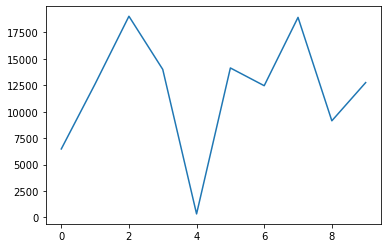

In [4]:
print(len(train_data))
xvals, yvals = np.unique([i[1] for i in train_data], return_counts=True) #This checks to see how well the augmentation went.
plt.plot(xvals, yvals, kind="bar", title="Class distribution after augmenting")
plt.savefig("classes_after_aug.png")

noise_std = imgs.std().numpy() * .2
print(noise_std)

## Model Training

In [5]:
learning_rate = 1e-3
batch_size = 64

device = "cuda" if torch.cuda.is_available() else "cpu"

from torch.nn import Conv2d
from torch.nn import ReLU
from torch.nn import MaxPool2d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn import LogSoftmax

In [6]:
class CNNClassifier(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=6,
            kernel_size=(7, 7))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv2 = Conv2d(in_channels=6, out_channels=12,
            kernel_size=(2, 2))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        
        self.flatten = Flatten()
        self.fc1 = Linear(in_features=15552, out_features=576)
        self.relu3 = ReLU()
        
        self.fc2 = Linear(in_features=576, out_features=64)
        self.relu4 = ReLU()
        self.fc3 = Linear(in_features=64, out_features=10)
        self.logSoftmax = LogSoftmax(dim=1)
        
        self.dropout = torch.nn.Dropout(0.25)
    
    def forward(self, x):
        # ------------------
        # Write your implementation here.        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.logSoftmax(x)
        y_output = x
        
        return y_output
        # ------------------

model_conv = CNNClassifier().to(device)

In [7]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

def add_noise(X):
    return X + torch.randn(X.shape) * noise_std

optimizer = torch.optim.Adam(model_conv.parameters(), lr=learning_rate, weight_decay = 1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    loss_l = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = add_noise(X).to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record metrics
        loss_l.append(loss)
        
        #print(batch)
        if batch % 64 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss_l
            
def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [8]:
epochs = 15
epoch_l = list(range(epochs))
data_seen = range(len(train_dataloader.dataset)*epochs)
test_l = []
correct_l = []
lost_tot = []
for t in epoch_l:
    print(f"Epoch {t+1}\n-------------------------------")
    lost_l = train_loop(train_dataloader, model_conv, loss_fn, optimizer, device)
    #exp_lr_scheduler.step()
    lost_tot.extend(lost_l)
    test_loss, correct = test_loop(test_dataloader, model_conv, loss_fn, device)
    test_l.append(test_loss)
    correct_l.append(correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295449  [   64/119894]
loss: 2.094612  [ 4160/119894]
loss: 2.170646  [ 8256/119894]
loss: 2.006219  [12352/119894]
loss: 1.968615  [16448/119894]
loss: 1.932258  [20544/119894]
loss: 1.970760  [24640/119894]
loss: 1.971855  [28736/119894]
loss: 1.991311  [32832/119894]
loss: 1.986613  [36928/119894]
loss: 1.949811  [41024/119894]
loss: 2.005097  [45120/119894]
loss: 1.855080  [49216/119894]
loss: 1.963904  [53312/119894]
loss: 1.755959  [57408/119894]
loss: 2.053234  [61504/119894]
loss: 1.918667  [65600/119894]
loss: 1.786875  [69696/119894]
loss: 1.871693  [73792/119894]
loss: 1.984303  [77888/119894]
loss: 1.885837  [81984/119894]
loss: 1.680016  [86080/119894]
loss: 1.789896  [90176/119894]
loss: 1.789102  [94272/119894]
loss: 2.068854  [98368/119894]
loss: 1.880050  [102464/119894]
loss: 1.833409  [106560/119894]
loss: 1.723884  [110656/119894]
loss: 1.712038  [114752/119894]
loss: 1.756613  [118848/119894]
Test Error: 
 Accuracy: 3

In [9]:
torch.save(model_conv, 'cnn_tl.pth')
torch.save(model_conv.state_dict(), 'cnn_states.pth')

In [10]:
train_losses = [i.cpu().detach().numpy() for i in lost_tot]
len(test_l)
scale = len(train_losses) // len(test_l)
print(scale)
ext_test_l = [test_l[i // scale] for i in range(len(train_losses))]

1874


In [11]:
print(len(train_losses))

28110


In [12]:
xaxis = [i * len(test_l) / len(train_losses) for i in range(len(train_losses))]

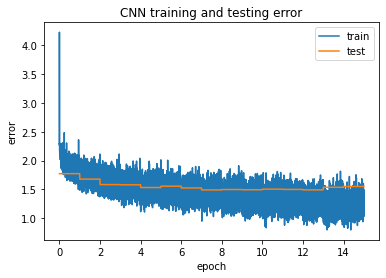

In [13]:
from matplotlib import pyplot as plt
plt.plot(xaxis, train_losses, label="train")
plt.plot(xaxis, ext_test_l, label="test")
plt.title("CNN training and testing error")
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()
plt.savefig("cnn training error.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

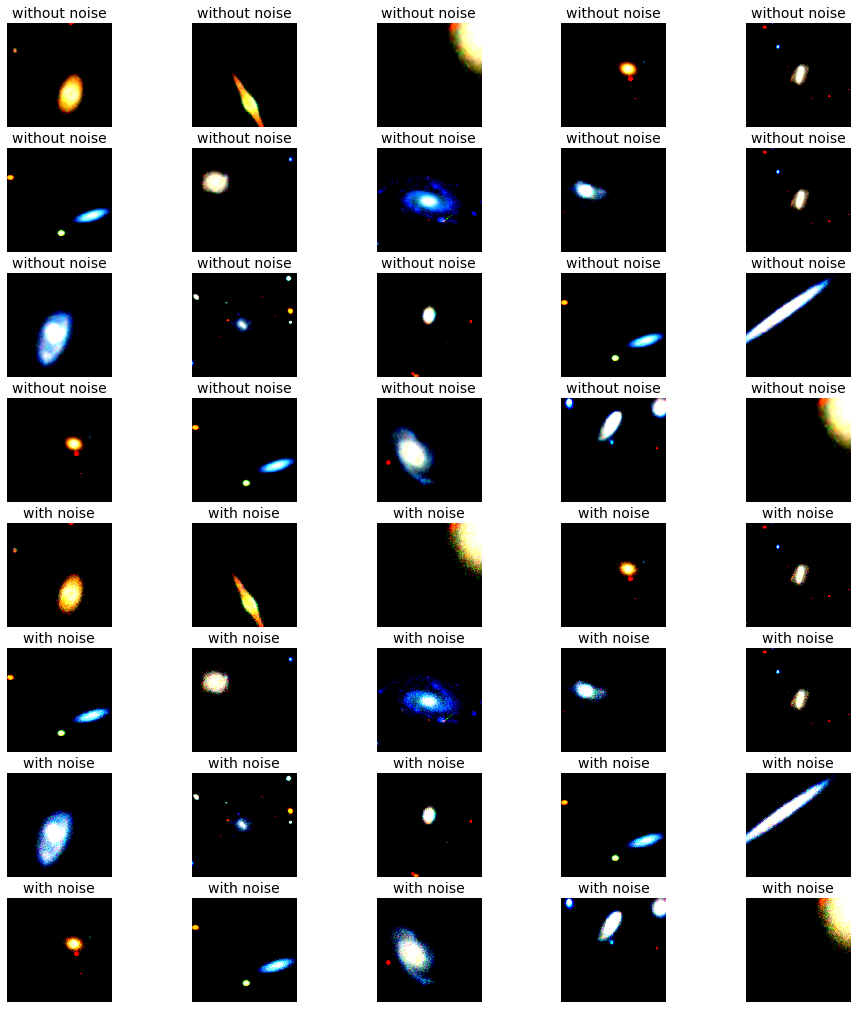

In [23]:
images, labels = next(iter(train_dataloader))
images = images.permute(0, 3, 2, 1)
fig = plt.figure(figsize=(16, 18))
# ------------------
classes = ('Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Smooth',
        'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on wo Bulge', 'Edge-on w Bulge')
# Write your implementation here
def visualize_images(images, labels, indices, add_noise_=False):
    for i in range(len(indices)):
        index = indices[i]
        plt.subplot(8, 5, i+1)
        if add_noise_:
            plt.imshow(add_noise(images[index]).squeeze(), interpolation='none')
        else:
            plt.imshow(images[index].squeeze(), interpolation='none')
        plt.title("without noise", fontsize=14)
        plt.axis('off')
    add_noise_ = True
    for i in range(len(indices)):
        index = indices[i]
        plt.subplot(8, 5, i+21)
        if add_noise_:
            plt.imshow(add_noise(images[index]).squeeze(), interpolation='none')
        else:
            plt.imshow(images[index].squeeze(), interpolation='none')
        plt.title("with noise", fontsize=14)
        plt.axis('off')
    
visualize_images(images, labels, random.choices(range(len(images)), k=20))
plt.savefig("Sample galaxies.png")
# ------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

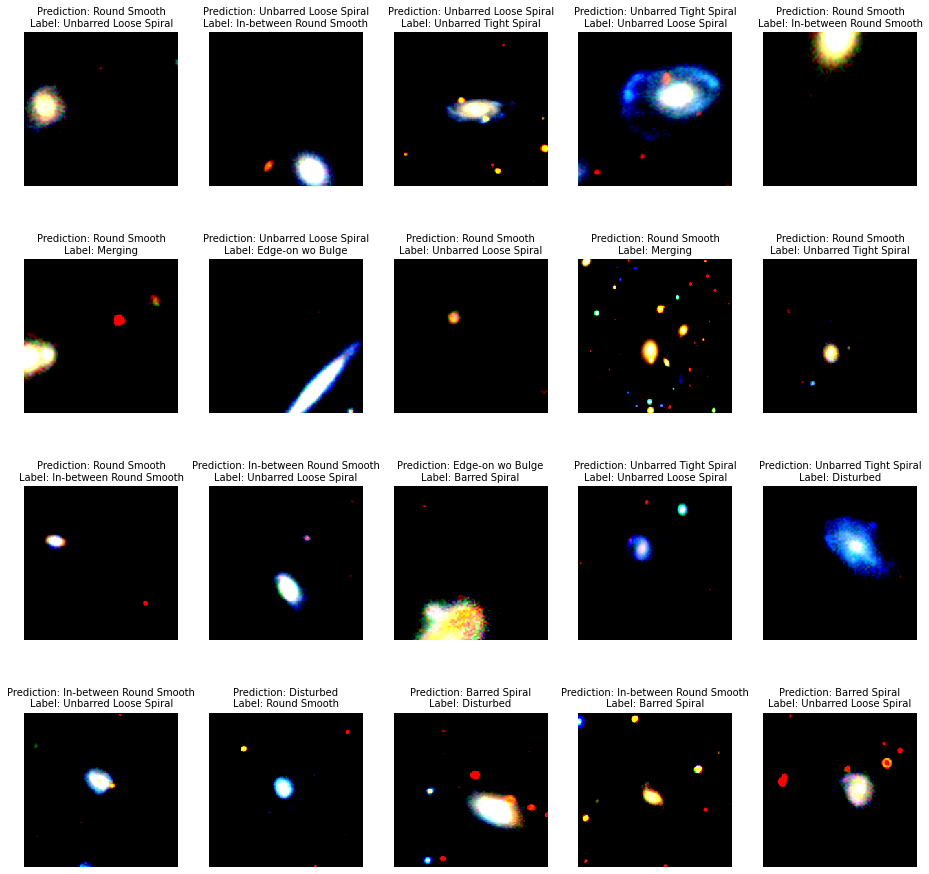

In [15]:
incorrect_imgs = torch.Tensor().to(device)
incorrect_preds = torch.IntTensor().to(device)
incorrect_labels = torch.IntTensor().to(device)

with torch.no_grad():
    # Test set iterator
    it = iter(test_dataloader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while incorrect_imgs.size(0) < 20:
        images, labels = next(it)
        images, labels = images.to(device), labels.to(device)

        # ------------------
        # Write your implementation here.

        output = model_conv.forward(images)
        pred = torch.argmax(output, axis=1)

        # Compare prediction and true labels and append the incorrect predictions
        # using `torch.cat`. 
        mask = pred != labels
        incorrect_imgs = images[mask]
        incorrect_preds = pred[mask]
        incorrect_labels = labels[mask]
incorrect_imgs = incorrect_imgs.permute(0, 3, 2, 1)

fig = plt.figure(figsize=(16, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {classes[incorrect_preds[i].item()]}\nLabel: {classes[incorrect_labels[i].item()]}', fontsize=10)
    plt.axis('off')
    plt.savefig("First 20 wrong predictions")

In [16]:
print(model_conv)

CNNClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=15552, out_features=576, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=576, out_features=64, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
y_pred = 
y_true = Y_train
    
# constant for classes
classes = ('Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Smooth',
        'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on wo Bulge', 'Edge-on w Bulge')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
conf_plot = sns.heatmap(df_cm, cmap="BuPu", annot=True, fmt='g')
fig = conf_plot.get_figure()
acc_score = accuracy_score(y_true, y_pred)
fig.suptitle(f'{model_name} Training Set Confusion Matrix, Acc Score:{acc_score:>0.3f}')
fig.savefig(f'plots/{model_name}_conf_mat_training.png', bbox_inches='tight', dpi=500)